In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [1]:
pip install torch torchvision pycocotools

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 7.1 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 23.0 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 41.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 7.1 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 20.5 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 11.0 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 7.0 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 34.3 MB/s eta 0:00:0000:0100:01
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82

In [1]:
import os
import shutil

src = "/kaggle/input/faster-rcnn/NewSonar_dataset2"
dst = "/kaggle/working/NewSonar_dataset2"

# Recursively copy the entire folder
shutil.copytree(src, dst)

print("✅ Dataset copied to working directory.")

✅ Dataset copied to working directory.


In [3]:
import os
import shutil

src = "/kaggle/input/epoch7th/fasterrcnn_resnet50_epoch_7.pth"
dst = "/kaggle/working/7thepoch"

# Recursively copy the entire folder
shutil.copy(src, dst)

print("✅ Dataset copied to working directory.")

✅ Dataset copied to working directory.


In [4]:
import torch
import torchvision
from torch.utils.data import DataLoader
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.datasets import CocoDetection
from torchvision.transforms import functional as F
import matplotlib.pyplot as plt
from PIL import Image

In [5]:
# Define transformations
class CocoTransform:
    def __call__(self, image, target):
        image = F.to_tensor(image)  # Convert PIL image to tensor
        return image, target

In [6]:
# Dataset class
def get_coco_dataset(img_dir, ann_file):
    return CocoDetection(
        root=img_dir,
        annFile=ann_file,
        transforms=CocoTransform()
    )

# Load datasets
train_dataset = get_coco_dataset(
    img_dir="/kaggle/working/NewSonar_dataset2/images/train",
    ann_file="/kaggle/working/NewSonar_dataset2/annotations_coco_train.json"
)


val_dataset = get_coco_dataset(
    img_dir="/kaggle/working/NewSonar_dataset2/images/val",
    ann_file="/kaggle/working/NewSonar_dataset2/annotations_coco_val.json"
)



# DataLoader
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, collate_fn=lambda x: tuple(zip(*x)))
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False, collate_fn=lambda x: tuple(zip(*x)))

loading annotations into memory...
Done (t=0.03s)
creating index...
index created!
loading annotations into memory...
Done (t=0.17s)
creating index...
index created!


In [7]:
# Load Faster R-CNN with ResNet-50 backbone
def get_model(num_classes):
    # Load pre-trained Faster R-CNN
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
    
    # Get the number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    
    # Replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    return model

In [8]:
num_classes = 11 # Background + chair, human, table
model = get_model(num_classes)

In [9]:
# Move model to GPU if available
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)

# Define optimizer and learning rate scheduler
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

In [10]:
def train_one_epoch(model, optimizer, data_loader, device, epoch):
    model.train()
    for images, targets in data_loader:
        # Move images to the device
        images = [img.to(device) for img in images]

        # Validate and process targets
        processed_targets = []
        valid_images = []
        for i, target in enumerate(targets):
            boxes = []
            labels = []
            for obj in target:
                # Extract bbox
                bbox = obj["bbox"]  # Format: [x, y, width, height]
                x, y, w, h = bbox

                # Ensure the width and height are positive
                if w > 0 and h > 0:
                    boxes.append([x, y, x + w, y + h])  # Convert to [x_min, y_min, x_max, y_max]
                    labels.append(obj["category_id"])

            # Only process if there are valid boxes
            if boxes:
                processed_target = {
                    "boxes": torch.tensor(boxes, dtype=torch.float32).to(device),
                    "labels": torch.tensor(labels, dtype=torch.int64).to(device),
                }
                processed_targets.append(processed_target)
                valid_images.append(images[i])  # Add only valid images

        # Skip iteration if no valid targets
        if not processed_targets:
            continue

        # Ensure images and targets are aligned
        images = valid_images

        # Forward pass
        loss_dict = model(images, processed_targets)
        losses = sum(loss for loss in loss_dict.values())

        # Backpropagation
        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

    print(f"Epoch [{epoch}] Loss: {losses.item():.4f}")

In [ ]:
# Training loop
num_epochs = 20
for epoch in range(num_epochs):
    train_one_epoch(model, optimizer, train_loader, device, epoch)
    lr_scheduler.step()
    
    # Save the model's state dictionary after every epoch
    model_path = f"fasterrcnn_resnet50_epoch_{epoch + 1}.pth"
    torch.save(model.state_dict(), model_path)
    print(f"Model saved: {model_path}")

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


Evaluating: 100%|██████████| 872/872 [01:07<00:00, 12.89it/s]


✅ Saved: result.csv with 2132 predictions
Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.46s).
Accumulating evaluation results...
DONE (t=0.14s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.535
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.949
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.539
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.141
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.536
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.451
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.607
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.610
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.610
 Average Recall     (AR) @

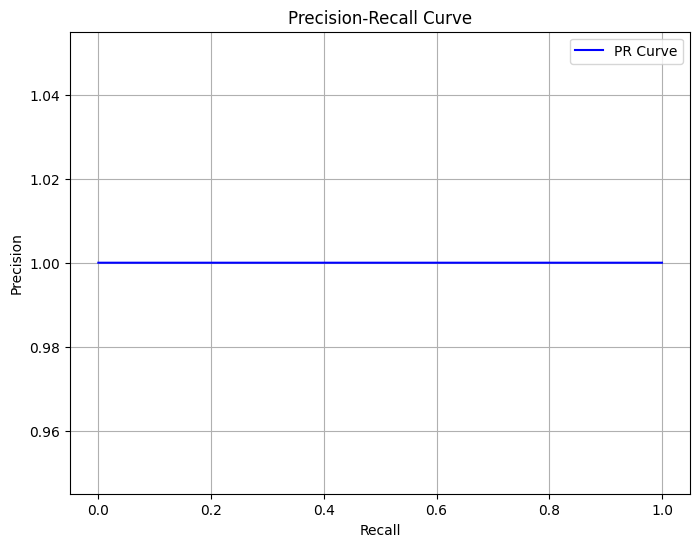

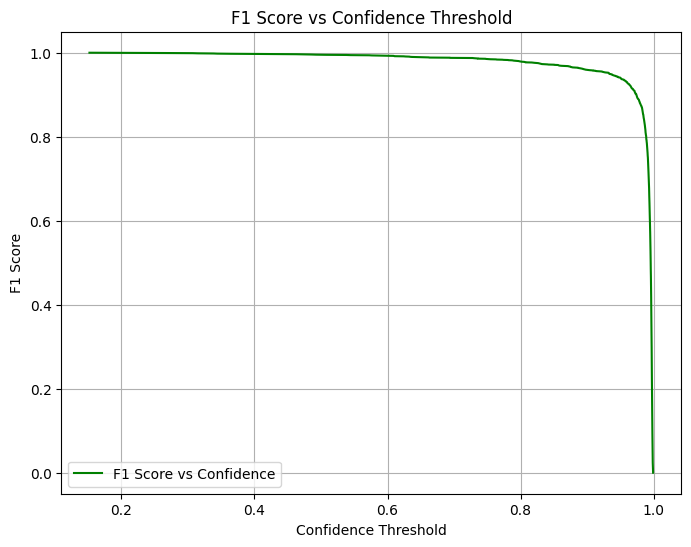

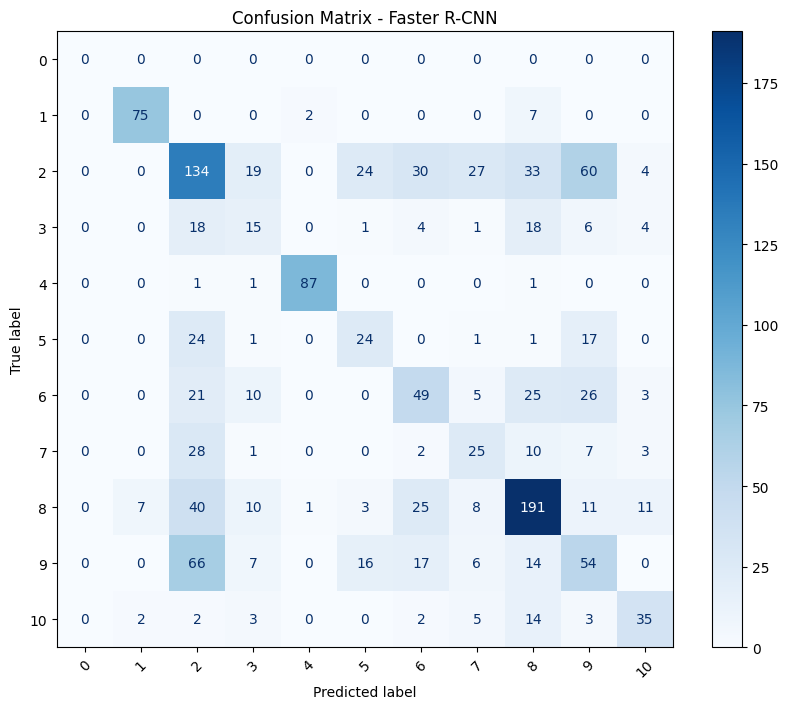

✅ All metrics saved and plots displayed successfully.


In [11]:
import os
import json
import torch
import pandas as pd
import numpy as np
from tqdm import tqdm
from PIL import Image

import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, confusion_matrix, ConfusionMatrixDisplay

from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.transforms import functional as F

from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval

# ====== Load model =======
def get_model(num_classes):
    model = fasterrcnn_resnet50_fpn(pretrained=True)
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    return model

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
num_classes = 11  # Update based on your dataset
model = get_model(num_classes)
model.load_state_dict(torch.load("/kaggle/working/7thepoch", map_location=device))
model.to(device)
model.eval()

# ====== Load test data =======
img_dir = "/kaggle/working/NewSonar_dataset2/images/test"
ann_file = "/kaggle/working/NewSonar_dataset2/annotations_coco_test.json"
coco_gt = COCO(ann_file)

# ✅ Patch 'info' to avoid KeyError during loadRes
if 'info' not in coco_gt.dataset:
    coco_gt.dataset['info'] = {"description": "auto-added for evaluation"}

# ====== Inference and save predictions =======
results = []
csv_rows = []

all_preds = []
all_scores = []
all_gts = []

for img_id in tqdm(coco_gt.getImgIds(), desc="Evaluating"):
    img_info = coco_gt.loadImgs(img_id)[0]
    file_name = img_info['file_name']
    img_path = os.path.join(img_dir, file_name)
    image = Image.open(img_path).convert("RGB")
    image_tensor = F.to_tensor(image).unsqueeze(0).to(device)

    with torch.no_grad():
        outputs = model(image_tensor)

    boxes = outputs[0]['boxes'].cpu().numpy()
    scores = outputs[0]['scores'].cpu().numpy()
    labels = outputs[0]['labels'].cpu().numpy()

    ann_ids = coco_gt.getAnnIds(imgIds=img_id)
    anns = coco_gt.loadAnns(ann_ids)
    gt_labels = [ann['category_id'] for ann in anns]

    all_gts.extend(gt_labels)
    all_preds.extend(labels[:len(gt_labels)])  # Align length
    all_scores.extend(scores[:len(gt_labels)])

    for box, score, label in zip(boxes, scores, labels):
        x_min, y_min, x_max, y_max = box
        width = x_max - x_min
        height = y_max - y_min

        results.append({
            "image_id": img_id,
            "category_id": int(label),
            "bbox": [float(x_min), float(y_min), float(width), float(height)],
            "score": float(score)
        })

        csv_rows.append({
            "image_id": img_id,
            "file_name": file_name,
            "category_id": int(label),
            "score": float(score),
            "x_min": float(x_min),
            "y_min": float(y_min),
            "width": float(width),
            "height": float(height)
        })

# ====== Save predictions =======
json_path = "/kaggle/working/fasterrcnn_predictions.json"
with open(json_path, "w") as f:
    json.dump(results, f)

csv_df = pd.DataFrame(csv_rows)
csv_df.to_csv("/kaggle/working/result.csv", index=False)
print(f"✅ Saved: result.csv with {len(csv_df)} predictions")

# ====== COCO Evaluation =======
coco_dt = coco_gt.loadRes(json_path)
coco_eval = COCOeval(coco_gt, coco_dt, iouType='bbox')
coco_eval.evaluate()
coco_eval.accumulate()
coco_eval.summarize()

# ====== Save selected COCO metrics =======
map_50_95 = float(coco_eval.stats[0])
map_50 = float(coco_eval.stats[1])
recall_100 = float(coco_eval.stats[8])

metrics_df = pd.DataFrame([{
    "mAP@0.5": round(map_50, 4),
    "mAP@0.5:0.95": round(map_50_95, 4),
    "Recall@100": round(recall_100, 4)
}])
metrics_df.to_csv("/kaggle/working/metrics_summary2.csv", index=False)
print("✅ Saved: metrics_summary2.csv")

# ====== PR Curve =======
binary_labels = [1 if x > 0 else 0 for x in all_preds]
binary_scores = all_scores[:len(binary_labels)]

precision, recall, thresholds = precision_recall_curve(binary_labels, binary_scores)
f1 = 2 * (precision * recall) / (precision + recall + 1e-6)

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label="PR Curve", color="blue")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.grid()
plt.legend()
plt.savefig("/kaggle/working/pr_curve.png")
plt.show()

# ====== F1 vs Confidence =======
plt.figure(figsize=(8, 6))
plt.plot(thresholds, f1[:-1], label="F1 Score vs Confidence", color="green")
plt.xlabel("Confidence Threshold")
plt.ylabel("F1 Score")
plt.title("F1 Score vs Confidence Threshold")
plt.grid()
plt.legend()
plt.savefig("/kaggle/working/f1_confidence_curve.png")
plt.show()

# ====== Confusion Matrix =======
min_len = min(len(all_gts), len(all_preds))
trimmed_gt = all_gts[:min_len]
trimmed_pred = all_preds[:min_len]

cm = confusion_matrix(trimmed_gt, trimmed_pred, labels=list(range(num_classes)))
fig, ax = plt.subplots(figsize=(10, 8))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[str(i) for i in range(num_classes)])
disp.plot(ax=ax, cmap="Blues", xticks_rotation=45)
plt.title("Confusion Matrix - Faster R-CNN")
plt.savefig("/kaggle/working/confusion_matrix.png")
plt.show()

print("✅ All metrics saved and plots displayed successfully.")


In [ ]:
import os
import json
import torch
import pandas as pd
from tqdm import tqdm
from PIL import Image

from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.transforms import functional as F

from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval

from sklearn.metrics import precision_recall_curve, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

# ====== Load model =======
def get_model(num_classes):
    model = fasterrcnn_resnet50_fpn(pretrained=True)
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    return model

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
num_classes = 11  # adjust to your dataset
model = get_model(num_classes)
model.load_state_dict(torch.load("/kaggle/working/7thepoch", map_location=device))
model.to(device)
model.eval()

# ====== Load COCO test set =======
img_dir = "/kaggle/working/NewSonar_dataset2/images/test"
ann_file = "/kaggle/working/NewSonar_dataset2/annotations_coco_test.json"
coco_gt = COCO(ann_file)

# ====== Inference and save results =======
results = []
csv_rows = []

all_gt = []
all_preds = []
all_scores = []

for img_id in tqdm(coco_gt.getImgIds(), desc="Evaluating"):
    img_info = coco_gt.loadImgs(img_id)[0]
    file_name = img_info['file_name']
    img_path = os.path.join(img_dir, file_name)

    image = Image.open(img_path).convert("RGB")
    image_tensor = F.to_tensor(image).unsqueeze(0).to(device)

    with torch.no_grad():
        outputs = model(image_tensor)

    boxes = outputs[0]['boxes'].cpu().numpy()
    scores = outputs[0]['scores'].cpu().numpy()
    labels = outputs[0]['labels'].cpu().numpy()

    ann_ids = coco_gt.getAnnIds(imgIds=img_id)
    anns = coco_gt.loadAnns(ann_ids)
    gt_labels = [ann['category_id'] for ann in anns]

    # Accumulate for PR/F1/confusion matrix
    all_gt.extend(gt_labels)
    all_preds.extend(labels[:len(gt_labels)])
    all_scores.extend(scores[:len(gt_labels)])

    for box, score, label in zip(boxes, scores, labels):
        x_min, y_min, x_max, y_max = box
        width = x_max - x_min
        height = y_max - y_min

        results.append({
            "image_id": img_id,
            "category_id": int(label),
            "bbox": [float(x_min), float(y_min), float(width), float(height)],
            "score": float(score)
        })

        csv_rows.append({
            "image_id": img_id,
            "file_name": file_name,
            "category_id": int(label),
            "score": float(score),
            "x_min": float(x_min),
            "y_min": float(y_min),
            "width": float(width),
            "height": float(height)
        })

# ====== Save predictions =======
json_path = "/kaggle/working/fasterrcnn_predictions.json"
with open(json_path, "w") as f:
    json.dump(results, f)

csv_df = pd.DataFrame(csv_rows)
csv_df.to_csv("/kaggle/working/result.csv", index=False)
print(f"✅ Saved result.csv with {len(csv_df)} rows")

# ====== COCO Evaluation =======
# FIX: Add dummy 'info' key if missing
if 'info' not in coco_gt.dataset:
    coco_gt.dataset['info'] = {"description": "Sonar test dataset"}

coco_dt = coco_gt.loadRes(json_path)
coco_eval = COCOeval(coco_gt, coco_dt, iouType='bbox')
coco_eval.evaluate()
coco_eval.accumulate()
coco_eval.summarize()

map_50_95 = float(coco_eval.stats[0])  # mAP@[.5:.95]
map_50 = float(coco_eval.stats[1])     # mAP@0.5
recall_100 = float(coco_eval.stats[8]) # AR@100

metrics_df = pd.DataFrame([{
    "mAP@0.5": round(map_50, 4),
    "mAP@0.5:0.95": round(map_50_95, 4),
    "Recall@100": round(recall_100, 4)
}])
metrics_df.to_csv("/kaggle/working/metrics_summary2.csv", index=False)
print("✅ Saved: /kaggle/working/metrics_summary2.csv")

# ====== PR Curve and F1 Curve =======
# ====== PR Curve and F1 Curve =======
# Use predicted labels as surrogate for binary classification
binary_labels = [1 if l > 0 else 0 for l in all_preds]
binary_scores = all_scores[:len(binary_labels)]  # Trim to match

precision, recall, thresholds = precision_recall_curve(binary_labels, binary_scores)
f1 = 2 * (precision * recall) / (precision + recall + 1e-6)

# PR Curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label="PR Curve", color="blue")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve (Binary)")
plt.grid()
plt.legend()
plt.savefig("/kaggle/working/pr_curve.png")
plt.show()

# F1 vs Confidence Curve
plt.figure(figsize=(8, 6))
plt.plot(thresholds, f1[:-1], label="F1 Score vs Confidence", color="green")
plt.xlabel("Confidence Threshold")
plt.ylabel("F1 Score")
plt.title("F1 Score vs Confidence Threshold")
plt.grid()
plt.legend()
plt.savefig("/kaggle/working/f1_confidence_curve.png")
plt.show()

# ====== Confusion Matrix =======
min_len = min(len(all_gt), len(all_preds))
all_gt_trimmed = all_gt[:min_len]
all_preds_trimmed = all_preds[:min_len]

cm = confusion_matrix(all_gt_trimmed, all_preds_trimmed, labels=list(range(num_classes)))
fig, ax = plt.subplots(figsize=(10, 8))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[str(i) for i in range(num_classes)])
disp.plot(ax=ax, cmap="Blues", xticks_rotation=45)
plt.title("Confusion Matrix - Faster R-CNN")
plt.savefig("/kaggle/working/confusion_matrix.png")
plt.show()



In [21]:
import os
import torch
import torchvision
from torch.utils.data import DataLoader
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.transforms import functional as F
import matplotlib.pyplot as plt
from PIL import Image

# =======================
# Load your trained model
# =======================

def get_model(num_classes):
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    return model

num_classes = 11  # Background + 10 custom classes
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

model = get_model(num_classes)
model.load_state_dict(torch.load("/kaggle/working/8thepoch/fasterrcnn_resnet50_epoch_7.pth", map_location=device))
model.to(device)
model.eval()

# ====================
# Class label mapping
# ====================

COCO_CLASSES = {
    0: "Background", 1: "plane", 2: "ball", 3: "human body", 4: "rov", 
    5: "metal bucket", 6: "square cage", 7: "circle cage", 8: "cube", 
    9: "tyre", 10: "cylinder"
}

def get_class_name(class_id):
    return COCO_CLASSES.get(class_id, "Unknown")

# ======================
# Image preprocessing
# ======================

def prepare_image(image_path):
    image = Image.open(image_path).convert("RGB")
    image_tensor = F.to_tensor(image).unsqueeze(0)
    return image_tensor.to(device), image

# ======================
# Draw and Save predictions
# ======================

def draw_and_save_boxes(image, prediction, output_path, fig_size=(10, 10), threshold=0.5):
    boxes = prediction[0]['boxes'].cpu().numpy()
    labels = prediction[0]['labels'].cpu().numpy()
    scores = prediction[0]['scores'].cpu().numpy()

    plt.figure(figsize=fig_size)
    plt.imshow(image)

    for box, label, score in zip(boxes, labels, scores):
        if score > threshold:
            x_min, y_min, x_max, y_max = box
            class_name = get_class_name(label)
            plt.gca().add_patch(plt.Rectangle((x_min, y_min), x_max - x_min, y_max - y_min,
                                              linewidth=2, edgecolor='red', facecolor='none'))
            plt.text(x_min, y_min, f"{class_name} ({score:.2f})", color='red', fontsize=10)

    plt.axis('off')
    plt.tight_layout()
    plt.savefig(output_path, bbox_inches='tight', pad_inches=0.1)
    plt.close()

# =========================
# Inference on all test images
# =========================

test_folder = "/kaggle/working/NewSonar_dataset2/images/test"
output_folder = "/kaggle/working/predicted_images"
os.makedirs(output_folder, exist_ok=True)

image_files = [f for f in os.listdir(test_folder) if f.lower().endswith(('.jpg', '.png', '.jpeg'))]

for image_file in image_files:
    image_path = os.path.join(test_folder, image_file)
    image_tensor, orig_image = prepare_image(image_path)

    with torch.no_grad():
        prediction = model(image_tensor)

    print(f"📷 {image_file} → Predicted {len(prediction[0]['boxes'])} objects")

    output_path = os.path.join(output_folder, f"pred_{image_file}")
    draw_and_save_boxes(orig_image, prediction, output_path, fig_size=(12, 10), threshold=0.5)
    print(f"✅ Saved: {output_path}")


📷 01050.jpg → Predicted 4 objects
✅ Saved: /kaggle/working/predicted_images/pred_01050.jpg
📷 01084.jpg → Predicted 4 objects
✅ Saved: /kaggle/working/predicted_images/pred_01084.jpg
📷 05306.jpg → Predicted 1 objects
✅ Saved: /kaggle/working/predicted_images/pred_05306.jpg
📷 01946.jpg → Predicted 1 objects
✅ Saved: /kaggle/working/predicted_images/pred_01946.jpg
📷 03080.jpg → Predicted 1 objects
✅ Saved: /kaggle/working/predicted_images/pred_03080.jpg
📷 05785.jpg → Predicted 7 objects
✅ Saved: /kaggle/working/predicted_images/pred_05785.jpg
📷 05700.jpg → Predicted 4 objects
✅ Saved: /kaggle/working/predicted_images/pred_05700.jpg
📷 04467.jpg → Predicted 6 objects
✅ Saved: /kaggle/working/predicted_images/pred_04467.jpg
📷 02228.jpg → Predicted 1 objects
✅ Saved: /kaggle/working/predicted_images/pred_02228.jpg
📷 01702.jpg → Predicted 2 objects
✅ Saved: /kaggle/working/predicted_images/pred_01702.jpg
📷 06762.jpg → Predicted 2 objects
✅ Saved: /kaggle/working/predicted_images/pred_06762.jpg

In [22]:
import shutil

shutil.make_archive("/kaggle/working/eval_results2", 'zip', "/kaggle/working/predicted_images")

'/kaggle/working/eval_results2.zip'